In [1]:
import torch
import PIL.Image
import matplotlib.pyplot as plt
import torchvision.transforms.v2

### Изображение

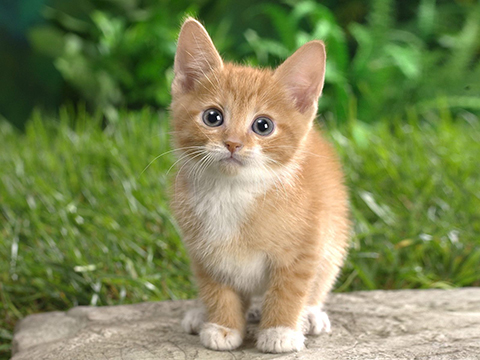

In [2]:
# Загрузим изображение котика
image = PIL.Image.open("image.jpg")
image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


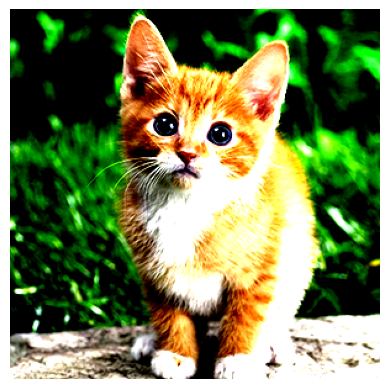

In [3]:
# Будем экспериментировать с efficientnet_b3. Подготовим картинку для применения этой модели.
# The inference transforms ... perform the following preprocessing operations:
transform = torchvision.transforms.v2.Compose([ # Accepts PIL.Image
    # The images are resized to resize_size=[320] using interpolation=InterpolationMode.BICUBIC
    torchvision.transforms.v2.Resize(320, interpolation = torchvision.transforms.v2.InterpolationMode.BICUBIC),
    # followed by a central crop of crop_size=[300].
    torchvision.transforms.v2.CenterCrop(300),
    # Finally the values are first rescaled to [0.0, 1.0]
    torchvision.transforms.v2.ToImage(),
    torchvision.transforms.v2.ToDtype(torch.float32, scale = True),
    # and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
    torchvision.transforms.v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
tensor = transform(image)
plt.axis('off')
plt.imshow(tensor.permute(1, 2, 0))
plt.show()

In [4]:
# Создадим батч, скопировав полученную картинку 64 раза.
input = torch.stack([ tensor ] * 64)
print(input.shape)

torch.Size([64, 3, 300, 300])


### Модель

In [5]:
# https://github.com/pytorch/vision/issues/7744
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return torch.hub.load_state_dict_from_url(self.url, *args, **kwargs)
torchvision.models._api.WeightsEnum.get_state_dict = get_state_dict

weights = torchvision.models.get_model_weights("efficientnet_b3").DEFAULT
model = torchvision.models.get_model("efficientnet_b3", weights = weights).eval()

In [6]:
output = model(input).detach()[0]
print(output.argmax())
print(output[0:7])

tensor(282)
tensor([-1.0213, -0.3629, -1.1130, -1.0600, -0.3761, -1.1208, -0.3966])


### Производительность

In [7]:
def test(device: torch.device) -> float:
    with torch.no_grad():
        return model.to(device)(input.to(device))

In [8]:
%timeit -r 10 test('cpu')

2.51 s ± 45.5 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [9]:
%timeit -r 100 test('cuda')

The slowest run took 15.46 times longer than the fastest. This could mean that an intermediate result is being cached.
263 ms ± 24.7 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)


In [10]:
model = model.to('cpu')
input = input.to('cpu')

### JIT

https://pytorch.org/docs/master/jit.html \
https://pytorch.org/tutorials/advanced/cpp_export.html

#### Tracing

In [11]:
traced_model = torch.jit.trace(model, input)
torch.allclose(traced_model(input).detach()[0], output)

True

In [12]:
traced_model.save("models/traced.pt")

#### Scripting

##### Problem

In [13]:
class TestModule(torch.nn.Module):
    def forward(self, input):
        if input.sum() > 0: return input.max(dim = 1).values
        else: return input.min(dim = 1).values
    
input1 = torch.tensor([ [ 1., 2. ], [ 3., 4. ] ])
input2 = torch.tensor([ [ 1., 2. ], [ -3., -4. ] ])

In [14]:
test_module = TestModule()
print(test_module(input1))
print(test_module(input2))

tensor([2., 4.])
tensor([ 1., -4.])


In [15]:
traced_test_module_1 = torch.jit.trace(test_module, input1)
print(traced_test_module_1(input1))
print(traced_test_module_1(input2))

tensor([2., 4.])
tensor([ 2., -3.])


C:\Users\TTPO100AJIEX\AppData\Local\Temp\ipykernel_7144\589776663.py:3: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if input.sum() > 0: return input.max(dim = 1).values


In [16]:
traced_test_module_2 = torch.jit.trace(test_module, input2)
print(traced_test_module_2(input1))
print(traced_test_module_2(input2))

tensor([1., 3.])
tensor([ 1., -4.])


C:\Users\TTPO100AJIEX\AppData\Local\Temp\ipykernel_7144\589776663.py:3: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if input.sum() > 0: return input.max(dim = 1).values


##### Solution

In [17]:
scripted_test_module = torch.jit.script(test_module)
print(scripted_test_module(input1))
print(scripted_test_module(input2))

tensor([2., 4.])
tensor([ 1., -4.])


In [18]:
scripted_model = torch.jit.script(model)
torch.allclose(scripted_model(input).detach()[0], output)

True

In [19]:
scripted_model.save("models/scripted.pt")

[onednn_fusion](https://pytorch.org/docs/stable/generated/torch.jit.enable_onednn_fusion.html#torch.jit.enable_onednn_fusion) \
[torch.jit.freeze()](https://pytorch.org/docs/stable/generated/torch.jit.freeze.html#torch.jit.freeze) \
[torch.jit.optimize_for_inference](https://pytorch.org/docs/stable/generated/torch.jit.optimize_for_inference.html) \
torch.jit.optimized_execution() - Не задокументировано

### ONNX

https://pytorch.org/docs/stable/onnx.html

#### TorchScript

https://pytorch.org/docs/stable/onnx_torchscript.html

In [20]:
torch.onnx.export(
    model, # traced_model, scripted_model
    input,
    "models/torchscript.onnx",
    input_names = [ "batch" ],
    output_names = [ "scores" ],
    dynamic_axes = {
        "batch": { 0: 'batch_size' },
        "scores": { 0: 'batch_size' }
    }
)

#### TorchDynamo

https://pytorch.org/docs/stable/onnx_dynamo.html

In [21]:
# Experimental, does not seem to work for efficientnet_b3
torchdynamo_model = torch.onnx.dynamo_export(
    model,
    input,
    export_options = torch.onnx.ExportOptions(dynamic_shapes = True)
)
torchdynamo_model.save("models/torchdynamo.onnx")

d:\Programs\Programming\Python\lib\site-packages\torch\onnx\_internal\exporter.py:130: UserWarning: torch.onnx.dynamo_export only implements opset version 18 for now. If you need to use a different opset version, please register them with register_custom_op.
  warnings.warn(


OnnxExporterError: Failed to export the model to ONNX. Generating SARIF report at 'report_dynamo_export.sarif'. SARIF is a standard format for the output of static analysis tools. SARIF logs can be loaded in VS Code SARIF viewer extension, or SARIF web viewer (https://microsoft.github.io/sarif-web-component/). Please report a bug on PyTorch Github: https://github.com/pytorch/pytorch/issues